In [2]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
from functools import reduce

import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import difflib
from scipy.optimize import linear_sum_assignment
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Crawling topuniversities.com

Running this code takes time, as ~1000 webpages need to be requested and parsed. The code was run only once, and the DataFrame was saved with pickle. Some postprocessing (renaming columns, etc) had to be done afterwards to minimize internet traffic.

In [3]:
## Later we will have a DataFrame where each cell has some html code in it from which
## we have to extract the necessary values. This function helps to run Beautifulsoup on
## each column at once instead of running it on each cells separately. The function
## helps to create a single string out of the column
def addS(x,y):
    if type(y) is str:
        return x+y + "\n"
    else:
        return x

We begin by requesting the data in the table of the "Ranking indicators" on https://www.topuniversities.com/university-rankings/world-university-rankings/2018 The table is actually populated using a json object that has the appropriate html code as cells.


In [3]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'
r = requests.get(URL)
page_body = r.text
jdata=json.loads(page_body)

Now we import the json object into pandas and extract the necessary information from each column using Beautfulsoup. For better performance we don't call Beautfulsoup on each cell, but rather transform each column into one string and call Beautfulsoup on that. For most of the cells the info is in the div with class=td-wrap-in, except the univerity name and link which had to be handled separately. 

In [4]:
PDdata=pd.DataFrame(jdata["data"])
PDdata=PDdata.loc[0:199] # we only need the top 200 unis

soup=BeautifulSoup(reduce(addS, PDdata["uni"].values), 'html.parser')
wrappers= soup.find_all('a')
PDdata["uni"]=[p.text for p in wrappers]
PDdata["link"]=[p['href'] for p in wrappers]

codes=["2971069","2971070","2971071","2971072","2971073","2971074"] # rest of the data 
for code in codes:
    soup=BeautifulSoup(reduce(addS, PDdata[code].values), 'html.parser')
    wrappers= soup.find_all('div',class_="td-wrap-in")
    PDdata[code][[not x for x in PDdata[code].isnull().values]]=[float(p.text) for p in wrappers]


## dropping unnecessary stuff, renaming columns 
drop_codes=["","2971069_rank_d","2971070_rank_d","2971071_rank_d","2971072_rank_d","2971073_rank_d","2971074_rank_d","_rank_d","overall","overall_rank_dis"]
PDdata=PDdata.drop(drop_codes,axis=1)
PDdata.columns=["academic reputation score",
                "citations per faculty score",
                "employer reputation score",
                "faculty-student score",
                "international faculty score",
                "international students score",
                "country",
                "overall rank",
                "region",
                "stars",
                "name",
                "link"]


## For some reason the type of these columns had to be set manually
PDdata["academic reputation score"]=PDdata["academic reputation score"].astype(float)
PDdata["citations per faculty score"]=PDdata["citations per faculty score"].astype(float)
PDdata["employer reputation score"]=PDdata["employer reputation score"].astype(float)
PDdata["faculty-student score"]=PDdata["faculty-student score"].astype(float)
PDdata["international students score"]=PDdata["international students score"].astype(float)
PDdata["international faculty score"]=PDdata["international faculty score"].astype(float)
PDdata["overall rank"]=PDdata["overall rank"].astype(int)


PDdata.dtypes

academic reputation score       float64
citations per faculty score     float64
employer reputation score       float64
faculty-student score           float64
international faculty score     float64
international students score    float64
country                          object
overall rank                      int64
region                           object
stars                            object
name                             object
link                             object
dtype: object

Since the info on the (international) students/faculty is not available here we need to visit the page dedicated to each university separately. This is the part of the code that takes a considerable amount of time. Note that the details page of NYU (index 51) doesn't have the necessary info. For index 189, we are missing only one entry, this we will fill separately.

In [5]:
url_data=np.full((PDdata.shape[0],4),np.nan)
for i in range(PDdata.shape[0]):
    URL = 'https://www.topuniversities.com/'+ PDdata["link"][i]
    r = requests.get(URL)
    page_body = r.text
    page_body

    soup = BeautifulSoup(page_body, 'html.parser')
    all_links = soup.find_all('div', class_='number')
    temp_data=[int(p.text[1:-1].replace(",","")) for p in all_links]
    if len(temp_data)==8:
        url_data[i,:]=temp_data[0:4]
    else:
        print(i)

51
189


In [6]:
URL = 'https://www.topuniversities.com/'+ PDdata["link"][189]
r = requests.get(URL)
page_body = r.text
page_body

soup = BeautifulSoup(page_body, 'html.parser')
all_links = soup.find_all('div', class_='number')
temp_data=[int(p.text[1:-1].replace(",","")) for p in all_links]
url_data[189,0]=temp_data[0]
url_data[189,2]=temp_data[1]
url_data[189,3]=temp_data[2]


In [7]:
PDdata["total faculty"]=url_data[:,0]
PDdata["international faculty"]=url_data[:,1]
PDdata["total students"]=url_data[:,2]
PDdata["international studets"]=url_data[:,3]

We also need to compute some new feautres for later use

In [9]:
PDdata["student-faculty ratio"]=np.divide(PDdata["total students"],PDdata["total faculty"])
PDdata["international student ratio"]=np.divide(PDdata["international studets"],PDdata["total students"])
PDdata["international faculty ratio"]=np.divide(PDdata["international faculty"],PDdata["total faculty"])
PDdata

,academic reputation score,citations per faculty score,employer reputation score,faculty-student score,international faculty score,international students score,country,overall rank,region,stars,name,link,total faculty,international faculty,total students,international studets,student-faculty ratio,international student ratio,international faculty ratio
0,100.0,99.9,100.0,100.0,100.0,96.1,United States,1,North America,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0,3.711268,0.335863,0.563045
1,100.0,99.4,100.0,100.0,99.6,72.7,United States,2,North America,5,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0,3.705484,0.227422,0.476546
2,100.0,99.9,100.0,98.3,96.5,75.2,United States,3,North America,5,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0,5.156092,0.234785,0.301379
3,99.5,100.0,85.4,100.0,93.4,89.2,United States,4,North America,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0,2.366212,0.286918,0.367261
4,100.0,78.3,100.0,100.0,97.4,97.7,United Kingdom,5,Europe,5,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0,3.418944,0.356899,0.414936
5,100.0,76.3,100.0,100.0,98.6,98.5,United Kingdom,6,Europe,5,University of Oxford,/universities/university-oxford,6750.0,2964.0,19720.0,7353.0,2.921481,0.372870,0.439111
6,99.7,74.7,99.5,99.1,96.6,100.0,United Kingdom,7,Europe,None,UCL (University College London),/universities/ucl-university-college-london,6345.0,2554.0,31080.0,14854.0,4.898345,0.477928,0.402522
7,99.4,68.7,100.0,100.0,100.0,100.0,United Kingdom,8,Europe,None,Imperial College London,/universities/imperial-college-london,3930.0,2071.0,16090.0,8746.0,4.094148,0.543567,0.526972
8,99.9,85.9,92.9,96.5,71.9,79.8,United States,9,North America,5,University of Chicago,/universities/university-chicago,2449.0,635.0,13557.0,3379.0,5.535729,0.249244,0.259290
9,99.6,98.7,99.4,68.2,100.0,98.8,Switzerland,10,Europe,None,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...,2477.0,1886.0,19815.0,7563.0,7.999596,0.381681,0.761405


Now we save the dataframe so we don't have to rerun the code.

In [10]:
PDdata.to_pickle("topuniversities.p")

In [11]:
PDdata=pd.read_pickle("topuniversities.p")

Now we will calculate the best countries in terms of student to staff ratio (highest considered best) and also in terms of percentage of international students (highest considered best):

In [12]:
PDdata.sort_values(ascending=[True], by=['student-faculty ratio'])[['name','overall rank','student-faculty ratio']].head(20)

,name,overall rank,student-faculty ratio
3,California Institute of Technology (Caltech),4,2.366212
15,Yale University,16,2.510526
5,University of Oxford,6,2.921481
4,University of Cambridge,5,3.418944
16,Johns Hopkins University,17,3.618557
1,Stanford University,2,3.705484
0,Massachusetts Institute of Technology (MIT),1,3.711268
185,University of Rochester,186,3.750876
18,University of Pennsylvania,19,3.753228
17,Columbia University,18,4.046696


In [13]:
PDdata.sort_values(ascending=[False], by=['international student ratio'])[['name','overall rank','international student ratio']].head(20)

,name,overall rank,international student ratio
34,London School of Economics and Political Scien...,35,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,0.570047
7,Imperial College London,8,0.543567
199,Maastricht University,200,0.502533
46,Carnegie Mellon University,47,0.478062
6,UCL (University College London),7,0.477928
91,University of St Andrews,92,0.457955
41,The University of Melbourne,41,0.427434
126,Queen Mary University of London,127,0.421816
25,The University of Hong Kong,26,0.407144


In [14]:
PDdata.sort_values(ascending=[False], by=['international faculty ratio'])[['name','overall rank','international faculty ratio']].head(20)

,name,overall rank,international faculty ratio
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,0.766962
9,ETH Zurich - Swiss Federal Institute of Techno...,10,0.761405
48,City University of Hong Kong,49,0.761305
29,The Hong Kong University of Science and Techno...,30,0.726087
25,The University of Hong Kong,26,0.692231
10,"Nanyang Technological University, Singapore (NTU)",11,0.689949
149,University of Basel,149,0.647114
34,London School of Economics and Political Scien...,35,0.631434
172,King Fahd University of Petroleum & Minerals,173,0.626177
14,National University of Singapore (NUS),15,0.604387


Now we want similar stats aggregated on country/region. As you can see below, UAE has the highest ratio of international students, with more than 50% of students being international.

In [15]:
PDdata.columns

Index(['academic reputation score', 'citations per faculty score',
       'employer reputation score', 'faculty-student score',
       'international faculty score', 'international students score',
       'country', 'overall rank', 'region', 'stars', 'name', 'link',
       'total faculty', 'international faculty', 'total students',
       'international studets', 'student-faculty ratio',
       'international student ratio', 'international faculty ratio'],
      dtype='object')

In [16]:
ranking_extended_1 = PDdata.copy()

cols_list = ['name', 'total faculty', 'international studets', 'total students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['international student ratio'] = df_agg['international studets']/df_agg['total students']
    df_agg['student-faculty ratio'] = df_agg['total students']/df_agg['total faculty']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_extended_1, 'country', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='international student ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
country,,,,,
Australia,22034.0,106359.0,301994.0,0.352189,13.705818
United Kingdom,79934.0,199426.0,583621.0,0.341705,7.301286
Hong Kong,10166.0,24499.0,78838.0,0.310751,7.755066
Austria,4117.0,19667.0,63446.0,0.309980,15.410736
Switzerland,15323.0,32995.0,109112.0,0.302396,7.120799
Singapore,9444.0,16168.0,58466.0,0.276537,6.190809
Canada,29317.0,73239.0,281514.0,0.260161,9.602415
New Zealand,3313.0,12439.0,48173.0,0.258215,14.540598
Ireland,2853.0,8187.0,34794.0,0.235299,12.195584


In [17]:
ranking_aggregated_country.sort_values(ascending=True, by='student-faculty ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
country,,,,,
Russia,6709.0,5098.0,30233.0,0.168624,4.506335
Denmark,11916.0,9543.0,67223.0,0.141960,5.641407
Saudi Arabia,1062.0,989.0,6040.0,0.163742,5.687382
Singapore,9444.0,16168.0,58466.0,0.276537,6.190809
Malaysia,2755.0,3476.0,17902.0,0.194168,6.498004
Japan,28395.0,16269.0,186222.0,0.087363,6.558267
South Korea,19851.0,16273.0,140071.0,0.116177,7.056118
Switzerland,15323.0,32995.0,109112.0,0.302396,7.120799
United Kingdom,79934.0,199426.0,583621.0,0.341705,7.301286


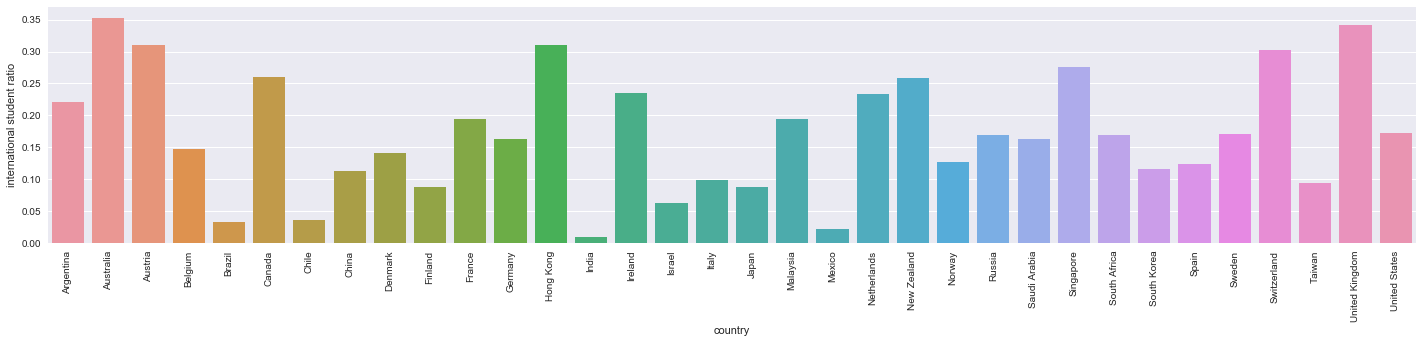

In [18]:
ax = sns.factorplot(kind = 'bar', x="country", y="international student ratio", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

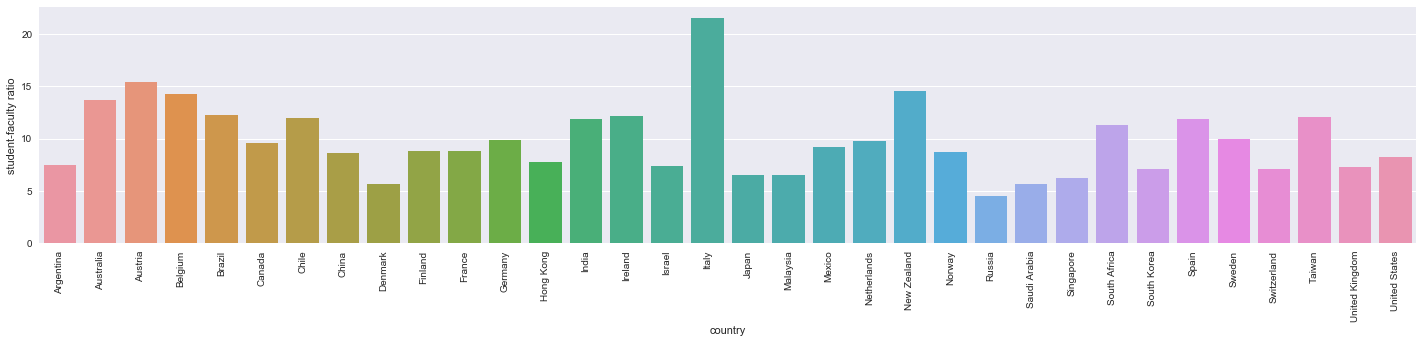

In [19]:
ax = sns.factorplot(kind = 'bar', x="country", y="student-faculty ratio", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

In [20]:
ranking_aggregated_region = do_country_region_agg(ranking_extended_1, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='international student ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
region,,,,,
Oceania,25347.0,118798.0,350167.0,0.339261,13.814929
Europe,223271.0,454293.0,1991280.0,0.228141,8.918668
North America,182123.0,292116.0,1546353.0,0.188906,8.490707
Africa,1733.0,3325.0,19593.0,0.169703,11.305828
Asia,106734.0,110100.0,807003.0,0.136431,7.560880
Latin America,43126.0,34737.0,396902.0,0.087520,9.203311


In [21]:
ranking_aggregated_region.sort_values(ascending=True, by='student-faculty ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
region,,,,,
Asia,106734.0,110100.0,807003.0,0.136431,7.560880
North America,182123.0,292116.0,1546353.0,0.188906,8.490707
Europe,223271.0,454293.0,1991280.0,0.228141,8.918668
Latin America,43126.0,34737.0,396902.0,0.087520,9.203311
Africa,1733.0,3325.0,19593.0,0.169703,11.305828
Oceania,25347.0,118798.0,350167.0,0.339261,13.814929


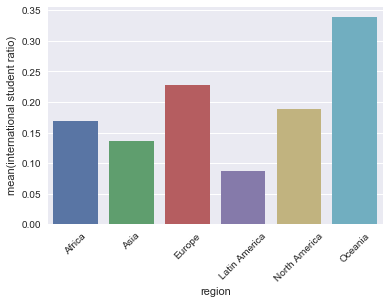

In [22]:
ax = sns.barplot(x="region", y="international student ratio", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

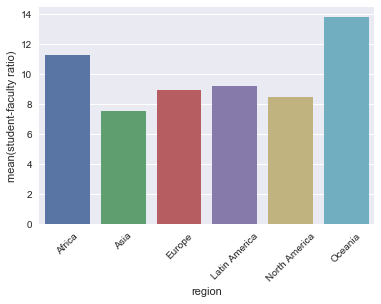

In [23]:
ax = sns.barplot(x="region", y="student-faculty ratio", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

## Crawling timeshighereducation.com

By looking at the GET requests sent by the browser when loading the world rankings page (using Postman), we have found the file that contains the data we need. We first send a GET request to receive it, and then turn it into a DataFrame and select only the columns that we need.

In [4]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
table_body = r.json()
df = pd.DataFrame(table_body['data'])
column_names = ['rank', 'name', 'location', 'url', 'scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook', 'stats_number_students',
   'stats_student_staff_ratio', 'stats_pc_intl_students']
ranking_complete=df[column_names]

In [5]:
ranking_complete.head()

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,"20,409",11.2,38%
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,"18,389",10.9,35%
2,=3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,"2,209",6.5,27%
3,=3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,"15,845",7.5,22%
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,"11,177",8.7,34%


All columns are of type 'object' right now, which is not what we want. In addition, some columns have certain characteristics:
* The stats_pc_intl_students column which is the percentage of international students, has a % sign.
* Values in stats_number_students have commas.
* In all of the score columns, in some rows we have values of the form a-b where a and b are numbers. We will take their average as the actual score.
* The rank column includes three types of irregularity: =i indicates a tie at rank i (we will remove the =), i-j indicates a rank range (we will take the average as the rank), and i+ indicates a rank above i (again we will simply remove the +). 

In [6]:
ranking_complete.loc[:,'stats_pc_intl_students'] = ranking_complete['stats_pc_intl_students'].apply(lambda x: float(x.strip('%'))/100.0)
ranking_complete.loc[:,'stats_number_students'] = ranking_complete.loc[:,'stats_number_students'].replace(',','',regex=True).values
ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'] = ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'].astype('float64')

C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
dash_character = '–'
def fix_float_value(value):
    if (str(value).find(dash_character) == -1):
        return float(value)
    parts = str(value).split(dash_character)
    return (float(parts[0])+float(parts[1]))/2.0

def fix_int_value(value):
    value = str(value)
    if (value.find(dash_character) == -1):
        if (value.find('=') == -1):
            if (value.find('+') == -1):
                return int(value)
            else:
                return int(value.strip('+'))
        else:
            return int(value.strip('='))
    else:
        parts = value.split(dash_character)
        return int((int(parts[0])+float(parts[1]))/2.0)
    
score_columns = ['scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook']
for col in score_columns:
    ranking_complete[col] = ranking_complete[col].apply(fix_float_value)

ranking_complete['rank'] = ranking_complete['rank'].apply(fix_int_value)
ranking_complete = ranking_complete[ranking_complete['rank'] <= 200]

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To add the region (which is missing from our data), we use the data contained in the __other__ dataset. To add the region (which is missing from our data), we use the data contained in the other dataset. First we make a dictionary that maps each country in the topuniversities table to its region in the same table. Then we try to get the region for all countries in the top 200 universities in the times table. However we figure out that there is no entry for universities in Luxembourg in topuniversities table. Also in the times table we have country name Russian Federation instead of Russia. So we fix this two issues by hand and add two entries to the dictionary. 
We also compute the total number of staff and total number of international students for each university (because they will be needed in the future for the aggregations over region or country).

In [8]:
topunis_data = pickle.load(open('topuniversities.p','rb'))
map_country = {u:v for u,v in zip(list(topunis_data['country']),list(topunis_data['region']))}
map_country['Luxembourg'] = 'Europe'
map_country['Russian Federation'] = 'Europe'
region = [map_country[c] for c in ranking_complete['location']]
ranking_complete['region'] = region
ranking_complete['total_staff'] = (ranking_complete['stats_number_students']/ranking_complete['stats_student_staff_ratio']).astype(int)
ranking_complete['total_intl_student'] = (ranking_complete['stats_number_students']*ranking_complete['stats_pc_intl_students']).astype(int)
ranking_w_region = ranking_complete

In [9]:
ranking_w_region.head()

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region,total_staff,total_intl_student
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,20409.0,11.2,0.38,Europe,1822,7755
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,18389.0,10.9,0.35,Europe,1687,6436
2,3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,2209.0,6.5,0.27,North America,339,596
3,3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,15845.0,7.5,0.22,North America,2112,3485
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,11177.0,8.7,0.34,North America,1284,3800


Now we will calculate the best countries in terms of student to staff ratio (lowest considered best) and also in terms of percentage of international students (highest considered best):

In [10]:
ranking_w_region.sort_values(ascending=[False], by=['stats_pc_intl_students'])[['name','rank','stats_pc_intl_students']].head(20)

,name,rank,stats_pc_intl_students
24,London School of Economics and Political Science,25,0.71
178,University of Luxembourg,179,0.57
37,École Polytechnique Fédérale de Lausanne,38,0.55
7,Imperial College London,8,0.55
102,Maastricht University,103,0.50
15,University College London,16,0.49
143,University of St Andrews,143,0.48
23,Carnegie Mellon University,24,0.45
120,Queen Mary University of London,121,0.45
39,University of Hong Kong,40,0.42


In [11]:
ranking_w_region.sort_values(ascending=[True], by=['stats_student_staff_ratio'])[['name','rank','stats_student_staff_ratio']].head(20)

,name,rank,stats_student_staff_ratio
105,Vanderbilt University,105,3.3
109,University of Copenhagen,109,4.1
12,Johns Hopkins University,13,4.3
11,Yale University,12,4.3
153,University of Rochester,153,4.3
97,Emory University,98,4.4
16,Duke University,17,4.5
114,École Polytechnique,115,5.1
183,Scuola Normale Superiore di Pisa,184,5.2
101,University of Pittsburgh,100,5.9


Now we want similar stats aggregated on country/region.

As you can see below, in the top 200 universities, Luxembourg has the highest ratio of international students.

In [12]:
cols_list = ['name', 'total_staff', 'total_intl_student', 'stats_number_students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['ratio_intl_student'] = df_agg['total_intl_student']/df_agg['stats_number_students']
    df_agg['ratio_student_staff'] = df_agg['stats_number_students']/df_agg['total_staff']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_w_region, 'location', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='ratio_intl_student').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Luxembourg,340,2832,4969.0,0.569934,14.614706
United Kingdom,44425,213045,596449.0,0.357189,13.425976
Hong Kong,4140,25157,77663.0,0.323925,18.759179
Australia,9937,83807,268630.0,0.311979,27.033310
Singapore,3364,17084,56101.0,0.304522,16.676873
Switzerland,10048,32743,107852.0,0.303592,10.733678
New Zealand,1614,8800,30348.0,0.289970,18.802974
Ireland,708,4362,16157.0,0.269976,22.820621
Austria,1700,9197,35375.0,0.259986,20.808824


And Denmark has the lowest student to staff ratio.

In [13]:
ranking_aggregated_country.sort_values(ascending=True, by='ratio_student_staff').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Denmark,10596,9326,64110.0,0.145469,6.050396
Russian Federation,4004,6431,29236.0,0.219969,7.301698
Japan,6464,4398,48481.0,0.090716,7.500155
Italy,157,132,1205.0,0.109544,7.675159
Switzerland,10048,32743,107852.0,0.303592,10.733678
United States,152317,280338,1705533.0,0.164370,11.197260
Taiwan,2761,2540,31758.0,0.079980,11.502354
South Africa,1775,3739,20775.0,0.179976,11.704225
China,21388,22879,253911.0,0.090106,11.871657


In [14]:
ranking_aggregated_country.describe()

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
count,27.000000,27.000000,2.700000e+01,27.000000,27.000000
mean,12900.851852,36775.666667,1.833059e+05,0.210223,16.433724
std,29301.785826,65392.247316,3.419531e+05,0.108363,7.954066
min,157.000000,132.000000,1.205000e+03,0.079980,6.050396
25%,1897.500000,4833.000000,3.105300e+04,0.136383,11.603290
50%,4140.000000,9326.000000,6.303500e+04,0.182654,14.614706
75%,10322.000000,28950.000000,1.851475e+05,0.279973,18.781076
max,152317.000000,280338.000000,1.705533e+06,0.569934,38.209566


And here are bar charts for the stats we calculated (1st one is international student ratio, 2nd one is student/staff ratio):

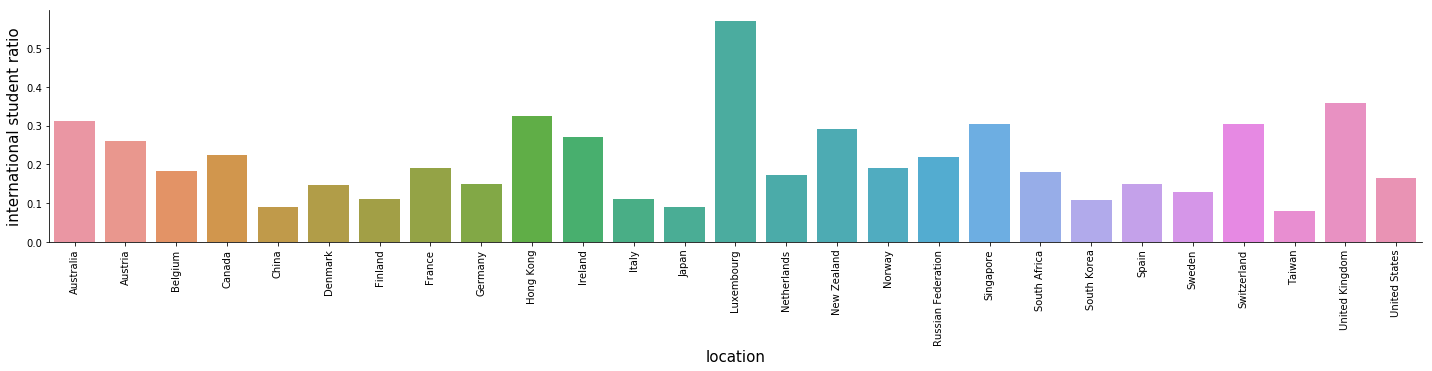

In [15]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_intl_student", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.ylabel('international student ratio', fontsize=15)
plt.xlabel('location', fontsize=15)
plt.xticks(rotation=90)
plt.show(ax)

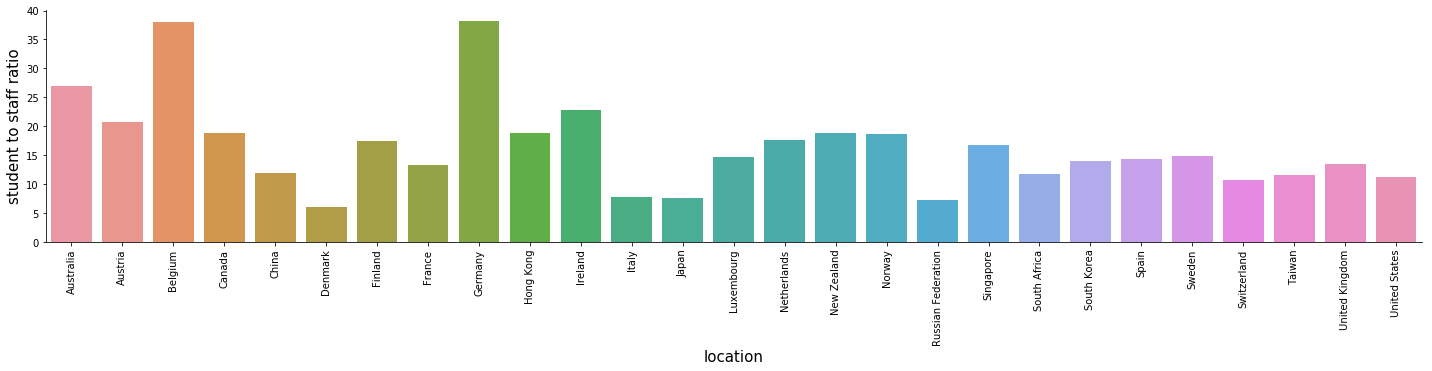

In [16]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_student_staff", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.ylabel('student to staff ratio', fontsize=15)
plt.xlabel('location', fontsize=15)
plt.xticks(rotation=90)
plt.show(ax)

And now aggregated by region: first sorted by ratio of international students and then by ratio of students to staff. We can see that Oceania has the highest international student ratio, while Asia has the lowest ratio. Also, Africa has the fewest students per staff while Oceania has the most.

In [17]:
ranking_aggregated_region = do_country_region_agg(ranking_w_region, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='ratio_intl_student').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Oceania,11551,92607,298978.0,0.309745,25.883300
Europe,126816,481530,2143623.0,0.224634,16.903411
Africa,1775,3739,20775.0,0.179976,11.704225
North America,165553,336240,1954934.0,0.171996,11.808508
Asia,42628,78827,530949.0,0.148464,12.455405


In [18]:
ranking_aggregated_region.sort_values(ascending=True, by='ratio_student_staff').head(20)

,total_staff,total_intl_student,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Africa,1775,3739,20775.0,0.179976,11.704225
North America,165553,336240,1954934.0,0.171996,11.808508
Asia,42628,78827,530949.0,0.148464,12.455405
Europe,126816,481530,2143623.0,0.224634,16.903411
Oceania,11551,92607,298978.0,0.309745,25.883300


Bar charts follow:

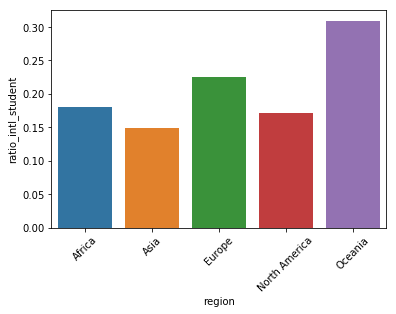

In [19]:
ax = sns.barplot(x="region", y="ratio_intl_student", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

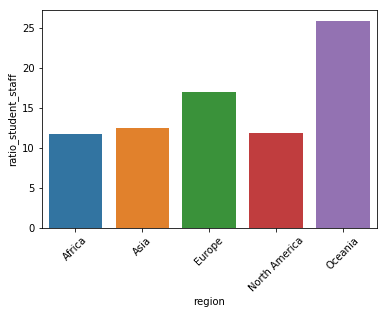

In [20]:
ax = sns.barplot(x="region", y="ratio_student_staff", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

Now, we have to merge the two dataframes. Our strategy is as follows:

* We run a mathcing algorithm on the rows of the two DataFrames, and save the best match of the topuniversities rows to a new column: "THE_indx"
* Then we join the two DataFrames based on the index column in times and the "THE_indx" column in the topuniversities.

#### A short note about the matching algorithm

For matching the university name in two tables we have to find the closest match between universities because a lot of universities don't have __exactly__ the same name in two tables. For this goal we use the _difflib_ and the _scipy.optimize_ libraries, their use will be explained below.

We create a (2x200 node) bipartite graphs from the rows of two dataframes of names. The edge weigths as chosen as follows:
- If the two rows come from different countries than the edge weight is 1000
- If they are from the same country we run a similarity function on their preporcessed names. The preprocessing removes of instances of "University" (in several languages), "The", "of" and " ". The similarity function is imported from the difflib library. According to the difflib documentation the idea is to find the longest contiguous matching subsequence that contains no “junk” elements, e.g. whitespaces/punctuation and sequences that are repeated too frequently (although the latter is only used for long strings). The same idea is then applied recursively to the pieces of the sequences to the left and to the right of the matching subsequence. This does not yield minimal edit sequences, but is instead designed to be biased towards matches that would appear more correct to the human eye.

Once the edge weights are computed we used we use linear_sum_assignment() from scipy.optimize which basically implements the Hungarian algorihtm to compute a minimum cost perfect matching. Then, since not all universities should be matched, we filter out those which had a weight larger than 0.5.


In [21]:
## Preprocess
topunis_data['stripped_name']=topunis_data['name']\
.apply(lambda x: x.replace("University",""))\
.apply(lambda x: x.replace("Universitaet",""))\
.apply(lambda x: x.replace("Universität",""))\
.apply(lambda x: x.replace("Université",""))\
.apply(lambda x: x.replace("Universiteit",""))\
.apply(lambda x: x.replace("The",""))\
.apply(lambda x: x.replace("of",""))\
.apply(lambda x: x.replace(" ",""))

ranking_w_region['stripped_name']=ranking_w_region['name']\
.apply(lambda x: x.replace("University",""))\
.apply(lambda x: x.replace("Universitaet",""))\
.apply(lambda x: x.replace("Universität",""))\
.apply(lambda x: x.replace("Université",""))\
.apply(lambda x: x.replace("Universiteit",""))\
.apply(lambda x: x.replace("The",""))\
.apply(lambda x: x.replace("of",""))\
.apply(lambda x: x.replace(" ",""))

## Compute weights
weights=np.full((len(topunis_data['stripped_name']),len(ranking_w_region['stripped_name'])),1000.0)
for i in range(len(topunis_data['stripped_name'])):
    for j in range(len(ranking_w_region['stripped_name'])):
        if topunis_data.loc[i,'country'] == ranking_w_region.loc[j,"location"]:
            s = difflib.SequenceMatcher(None, topunis_data.loc[i,"stripped_name"], ranking_w_region.loc[j,"stripped_name"])
            weights[i,j]=1-s.ratio()

## Filter and save
row_ind, col_ind = linear_sum_assignment(weights)
topunis_data["THE_indx"]=np.zeros(len(col_ind))
for i in range(len(col_ind)):
    if (weights[i,col_ind[i]]<0.5):
        topunis_data.loc[i,"THE_indx"]=col_ind[i]
    else:
        topunis_data.loc[i,"THE_indx"]=-1
        
#temp=list(map(lambda x: difflib.get_close_matches(x[0], ranking_w_region.loc[ranking_w_region["location"]==x[1],"stripped_name"],n=1, cutoff=0.51)
#    ,zip(topunis_data['stripped_name'].values,topunis_data['country'].values)))
#topunis_data["closest"]=list(map(lambda x: x[0] if len(x)>0 else "",temp))


We rename the columns of our dataset by adding THE to the beginning to avoid mixing them up with columns from the other dataset.

In [22]:
## Renaming the columns so that they are more readable after merging
the_columns_renamed = {col:'THE_'+col for col in ranking_w_region.columns}
ranking_w_region = ranking_w_region.rename(columns=the_columns_renamed)

topunis_data_cols_renamed = {col:'TOPU_'+col for col in topunis_data.columns}
topunis_data = topunis_data.rename(columns = topunis_data_cols_renamed)


We can see that not all universities have a match; some universities that fall within the top 200 in one database are not in the top 200 in the other. However, 159 out of 200 is still a pretty respectable number and shows that there is a lot of similarity between the two datasets.

In [23]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

merged_dataframes = pd.merge(ranking_w_region, topunis_data, right_on='TOPU_THE_indx', left_index=True)
merged_dataframes.shape

(159, 38)

Our algorithm seams pretty good, we didn't see any mistakes after a quick check

In [24]:
merged_dataframes[['THE_name','TOPU_name']]


,THE_name,TOPU_name
5,University of Oxford,University of Oxford
4,University of Cambridge,University of Cambridge
3,California Institute of Technology,California Institute of Technology (Caltech)
1,Stanford University,Stanford University
0,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)
2,Harvard University,Harvard University
12,Princeton University,Princeton University
7,Imperial College London,Imperial College London
8,University of Chicago,University of Chicago
9,ETH Zurich – Swiss Federal Institute of Techno...,ETH Zurich - Swiss Federal Institute of Techno...


#### Correlation between variables in the dataset
Bellow we can see a heatmap of correaltion between all pairs of variables in the merged dataset. 

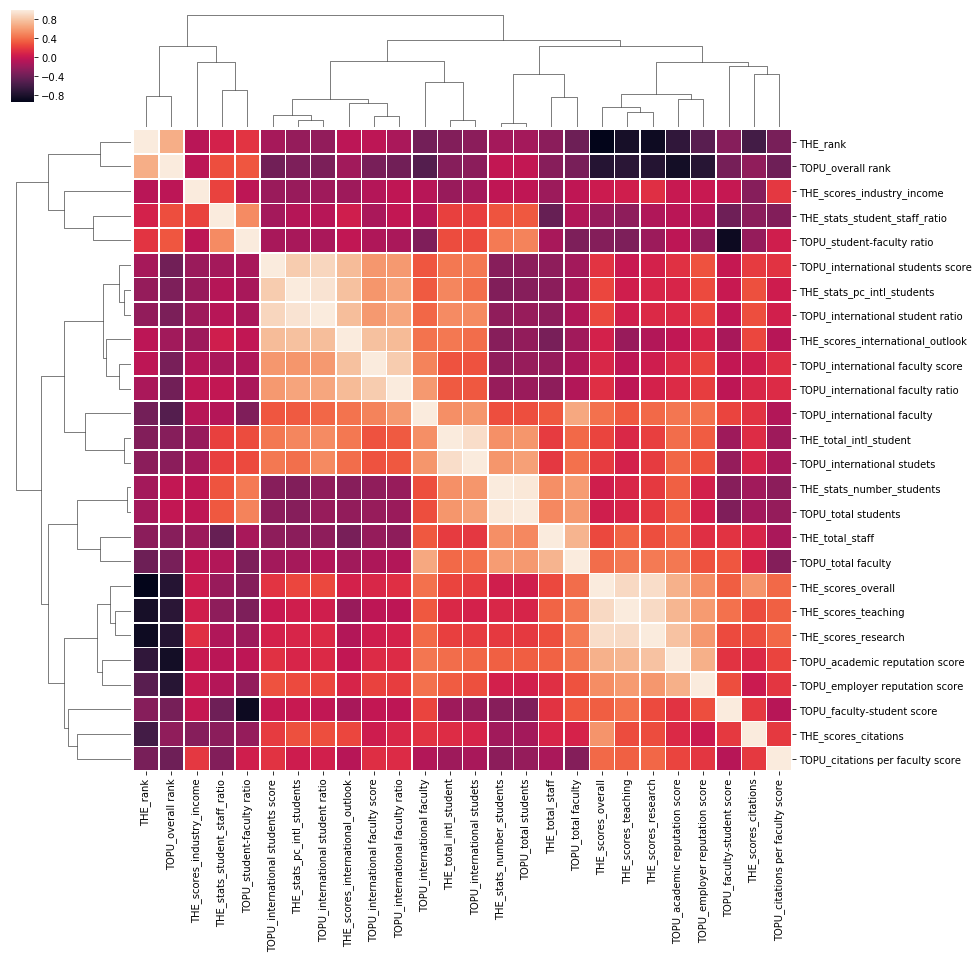

In [25]:
cg = sns.clustermap(merged_dataframes.corr(), linewidth=.5, figsize=(14,14))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


Now we arrive at the joint scoring part. THE dataset (that's one hell of a pun isn't it) has 5 scoring columns (plus one total score column) and the TopUnis dataset has 6 scoring columns. The first idea is to simply take the average of those 5 in THE together and those 6 in TopUnis together, and then take the average of these two scores as the final score of the university. Let's take a look:

In [26]:
the_score_cols = ['THE_scores_teaching', 'THE_scores_research', 'THE_scores_citations', 'THE_scores_industry_income', 'THE_scores_international_outlook']
topu_score_cols = ['TOPU_academic reputation score', 'TOPU_citations per faculty score', 'TOPU_employer reputation score', 'TOPU_faculty-student score', 'TOPU_international faculty score', 'TOPU_international students score']
the_score_series = [merged_dataframes[col] for col in the_score_cols]
the_avg_score = sum(the_score_series)/5
topu_score_series = [merged_dataframes[col] for col in the_score_cols]
topu_avg_score = sum(topu_score_series)/6

In [27]:
new_rankings_df = merged_dataframes.copy()
new_rankings_df['Total score'] = (the_avg_score+topu_avg_score)/2
new_rankings_df[['THE_name', 'Total score']].sort_values(by='Total score', ascending=False).reset_index().drop('index',axis=1).rename(columns={'THE_name':'name'})

,name,Total score
0,Massachusetts Institute of Technology,83.453333
1,University of Oxford,81.400000
2,California Institute of Technology,80.593333
3,Imperial College London,79.805000
4,Johns Hopkins University,78.650000
5,University of Cambridge,78.393333
6,Stanford University,77.696667
7,Duke University,77.385000
8,ETH Zurich – Swiss Federal Institute of Techno...,77.201667
9,Princeton University,76.248333
